In [1]:
import os, sys
sys.path.append('../../')
import neurons

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = 'viridis'

spec_norm = Normalize(0, 1)
spec_mapp = ScalarMappable(cmap=cmap, norm=spec_norm)

spike_norm = Normalize(-100, 50)
spike_mapp = ScalarMappable(cmap=cmap, norm=spike_norm)

# Load Data

In [2]:
x_train = np.load('../mnist_classification/data/x_train.npy')
y_train = np.load('../mnist_classification/data/y_train.npy')

x_test = np.load('../mnist_classification/data/x_test.npy')
y_test = np.load('../mnist_classification/data/y_test.npy')

In [3]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [4]:
def show_image(image):
    fig, ax = plt.subplots(figsize=(4,4), dpi=80)
    im = ax.imshow(image)
    ax.axis('off')
#     fig.colorbar(im, ax=ax)
    plt.show()

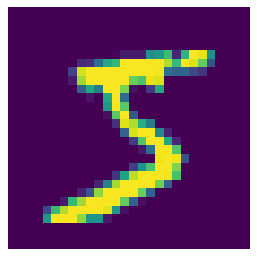

In [5]:
show_image(x_train[0])

### restructure data for training

In [6]:
masks = {}
for i in range(10):
    masks[i] = y_train == i
    
masks_test = {}
for i in range(10):
    masks_test[i] = y_test == i

In [7]:
data = {}
for i in range(10):
    data[i] = x_train[masks[i]]
    
data_t = {}
for i in range(10):
    data_t[i] = x_test[masks_test[i]]

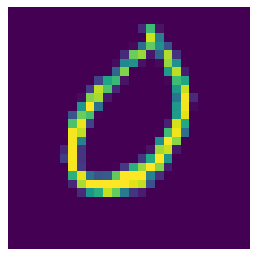

In [8]:
show_image(data[0][2230])

# Define Network Architecture

In [9]:
net = neurons.Network()
ntype = neurons.LIFrate

params = {
    'v_rest': -70,
    'v_thres': -55,
    'R': 100,
    'tau_v': 0.1,
    'gamma': 0.1,
    'theta': 0.5,
    'tau_s': 10
}

In [10]:
net.add(neurons.Sensory, 784, 'input')
net.add(ntype, 1200, 'hidden', **params)

In [11]:
net.connect('input', 'hidden')

In [12]:
net.compile()

network successfully compiled.



In [13]:
dec = neurons.Decoder(1200, 10)

# Define some functions for plotting

In [14]:
def plot_synapses(synapses):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Synaptic Weights')
    ax.set_xlabel('Pre-Synaptic Neuron')
    ax.set_ylabel('Post-Synaptic Neuron')
    im = ax.pcolormesh(np.arange(synapses.shape[1]), np.arange(synapses.shape[0]), synapses, shading='nearest', cmap=cmap)#, norm=Normalize(-1,1))
    fig.colorbar(im, ax=ax)
    plt.show()

In [15]:
def plot_voltage(voltage_history, **kwargs):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Membrane Potential')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron #')
    ax.set(**kwargs)
    im = ax.pcolormesh(np.arange(voltage_history.shape[0]) * dt, np.arange(voltage_history.shape[1]), voltage_history.T, shading='nearest', cmap=cmap)
    fig.colorbar(im, ax=ax, label='Voltage [mV]')
    plt.show()

In [16]:
def plot_outputs(output_history, **kwargs):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Spikes')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron #')
    ax.set(**kwargs)
    im = ax.pcolormesh(np.arange(output_history.shape[0]) * dt, np.arange(output_history.shape[1]), output_history.T, shading='nearest', cmap='gray_r', norm=Normalize(0,1))
    ax.grid(alpha=0.2)
    fig.colorbar(im, ax=ax, label='Firing Rate [1/max_rate]')
    plt.show()

In [17]:
def plot_history_choice(history, choice=0, title=None, **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,10), dpi=80, sharex=True, constrained_layout=True)
    fig.suptitle(title)
    
    ax1.set_title('current')
    ax1.plot(np.arange(history.current.shape[0]) * dt, history.current.T[choice], lw=1)
    ax1.set_ylabel('current [mA]')
    ax1.set(**kwargs)
    ax1.grid(alpha=0.2)
    
    ax2.set_title('membrane potential')
    ax2.plot(np.arange(history.voltage.shape[0]) * dt, history.voltage.T[choice], '-', lw=1)
    ax2.set_ylabel('voltage [mV]')
#     ax2.set_ylim(-120, 0)
    ax2.set(**kwargs)
    ax2.grid(alpha=0.2)
    
    ax3.set_title('spikes')
    ax3.plot(np.arange(history.outputs.shape[0]) * dt, history.outputs.T[choice], '-', lw=1)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('firing rate')
    ax3.set_ylim(0,1)
    ax3.set(**kwargs)
    ax3.grid(alpha=0.2)
    
    plt.show()

# Training Simulation

In [18]:
# dec.decoders = np.load('decoders.npy')

In [19]:
dec.tau = 100

In [61]:
net.reset_history()
net.record_history = True
dec.train = True
dec._history = []

dt = 0.001
time_per_digit = 1

n_digits = 500
start = 1500

steps_per_digit = int(time_per_digit / dt)
steps = steps_per_digit * n_digits
time = time_per_digit * n_digits

print(f"total time: {time} seconds")
print(f"time_per_digit: {time_per_digit} seconds")
print()
print(f"dt: {dt}")
print(f"steps per digit: {steps_per_digit}")
print(f"total_steps: {steps}")
print()

print("begin simulation...")
for i in range(start, start + n_digits):
    for j in range(steps_per_digit):
        if j == 0:
            net.bundles['input'].outputs[:] = x_train[i].reshape(-1)
            dec.premise = np.array([l == y_train[i] for l in range(10)]).astype(np.float32)
        
        dec.inputs = net.bundles['hidden'].outputs
        net.step(dt)
        dec.step(dt)
        dec._history.append(dec.outputs)
        print(f'{((i-start) * steps_per_digit + j)/steps*100:.2f}%', end='\r')

print('simulation ended.')

total time: 500 seconds
time_per_digit: 1 seconds

dt: 0.001
steps per digit: 1000
total_steps: 500000

begin simulation...
simulation ended.


## Network Analysis after Training Simulation

In [62]:
# plot_history_choice(net.history['hidden'], choice=1)

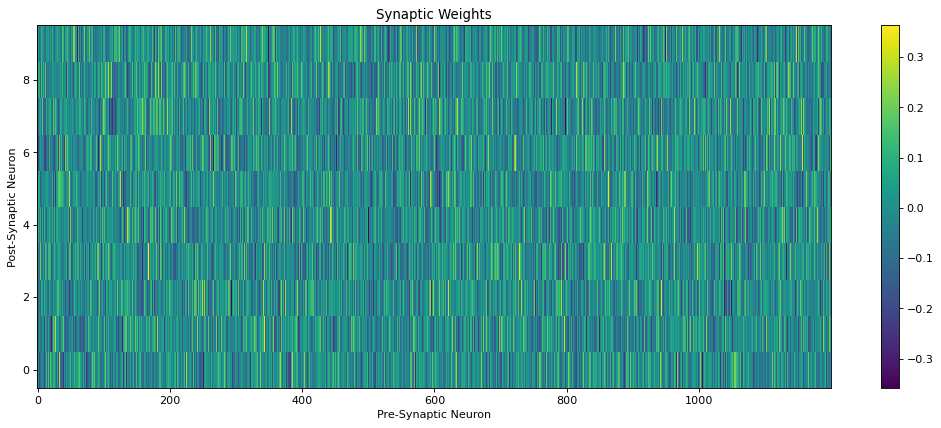

In [63]:
plot_synapses(dec.decoders)

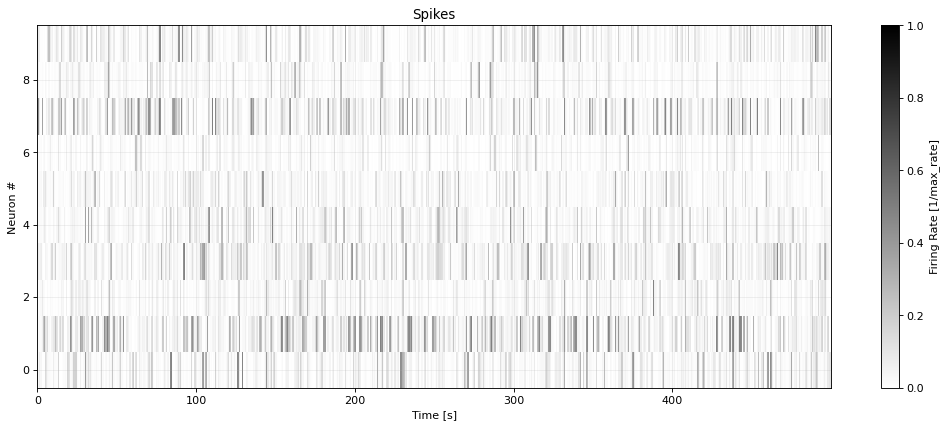

In [64]:
plot_outputs(dec.history)

# Evaluation Simulation on Test Data

In [65]:
steps = 1000

net.bundles['input'].outputs[:] = 0

for i in range(steps):
    net.step(dt)
    print(f'{(i+1)/steps*100:.2f}%', end='\r')

In [66]:
net.reset_history()
net.record_history = True
dec.train = False
dec._history = []
predictions = []


dt = 0.001
time_per_digit = 1

n_digits = 20
start = 0

steps_per_digit = int(time_per_digit / dt)
steps = steps_per_digit * n_digits
time = time_per_digit * n_digits

print(f"total time: {time} seconds")
print(f"time_per_digit: {time_per_digit} seconds")
print()
print(f"dt: {dt}")
print(f"steps per digit: {steps_per_digit}")
print(f"total_steps: {steps}")
print()

print("begin simulation...")
for i in range(start, start + n_digits):
    for j in range(steps_per_digit):
        if j == 0:
            net.bundles['input'].outputs[:] = x_test[i].reshape(-1)
        
        dec.inputs = net.bundles['hidden'].outputs
        net.step(dt)
        dec.step(dt)
        dec._history.append(dec.outputs)
        
        if j+1 == steps_per_digit:
            predictions.append(np.argmax(dec.outputs))
        
        print(f'{((i-start) * steps_per_digit + j)/steps*100:.2f}%', end='\r')

predictions = np.array(predictions)
print('simulation ended.')

total time: 20 seconds
time_per_digit: 1 seconds

dt: 0.001
steps per digit: 1000
total_steps: 20000

begin simulation...
simulation ended.


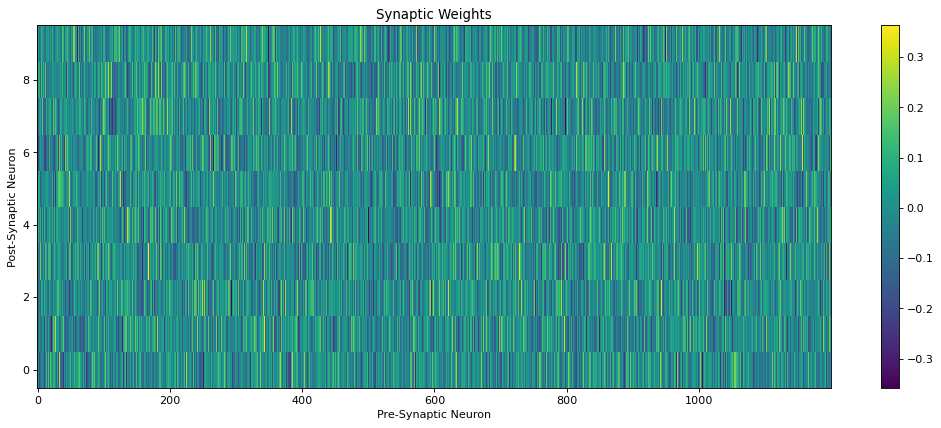

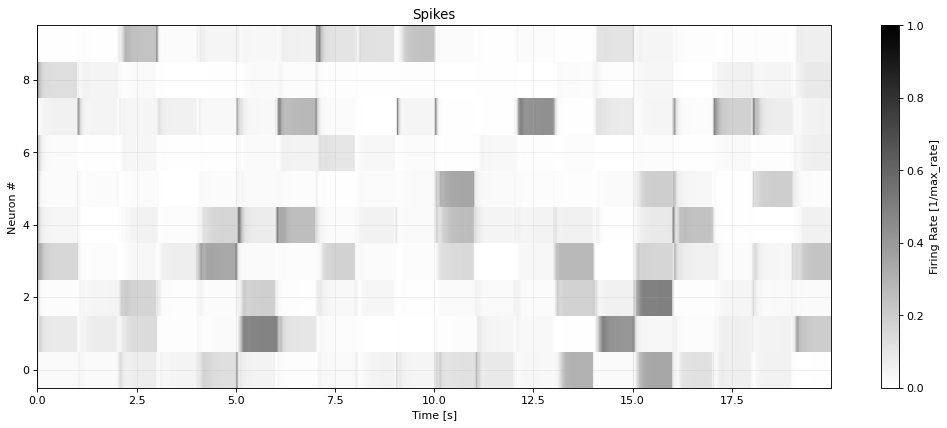

In [67]:
plot_synapses(dec.decoders)
plot_outputs(dec.history)

In [68]:
print(y_test[start:start+int(time/time_per_digit)].astype(np.int).shape)
print(predictions.shape)

(20,)
(20,)


In [72]:
scores = y_test[start:start+int(time/time_per_digit)] == predictions

print(np.mean(scores))

0.25


In [70]:
# for i in range(start, int(start + steps / time_per_digit * dt)):
#     print('label:      ', int(y_test[i]))
#     print('prediction: ', predictions[i])
#     show_image(x_test[i])

In [71]:
# np.save('decoders.npy', dec.decoders)